In [ ]:
import pandas as pd
import numpy as np
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


### File paths

In [ ]:
training_data_path = '/content/drive/MyDrive/Dortmund/W06_training.txt'
scoring_dataset_path = '/content/drive/MyDrive/Dortmund/W06_scoring.txt'

## Exercise 1

### Preparing the data

In [ ]:
#Import the data set "W06_training.txt"
train_set = pd.read_csv('/content/drive/MyDrive/Dortmund/W06_training.txt', sep= ";")
train_set.head()

In [ ]:
#Use only the first 7 columns (i.e. ignore the "Fraud" column for now)
train_set = train_set.drop("Fraud",axis=1)
train_set

In [ ]:
# Divide each column by its maximum value , so that each each column is scaled between 0 and 1
train_set = train_set.apply(lambda x: x / x.max())

### Exercise 1.1. 

Perform a principal component analysis. Report the explained variance ratio and the components of the first two principal components

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(train_set)
pca

In [ ]:
print(pca.explained_variance_ratio_)

In [ ]:
pca.components_

### Exercise 1.2.

Perform a k means cluster analysis to derive a solution with 3 clusters. For
comparison use KMeans n_clusters =3, random_state =100 ) to always get the
same results. Report the components of the cluster centers and the size of the
clusters (i.e. the number of data points assigned to each cluster

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=100).fit(train_set)

In [ ]:
kmeans.cluster_centers_

In [ ]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

## Exercise 2

### Get an overview and understanding of the available training data

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_data = pd.read_csv(training_data_path, sep= ";")
train_data.head()

NameError: ignored

In [ ]:
set_to_be_scored = pd.read_csv(scoring_dataset_path, sep= ";")
set_to_be_scored.head()

In [ ]:
train_data.describe()

#### We analize each feature's distribution by both target classes: Fraud & Non-Fraud to detect different behaviour 

In [ ]:
for col in train_data.columns[:-1]:
  colors = ['yellowgreen','coral']
  col_fraud = train_data[train_data['Fraud'] == 1][col]
  col_non_fraud = train_data[train_data['Fraud'] == 0][col]
  col_fraud_w = np.empty(col_fraud.shape)
  col_fraud_w.fill(1/col_fraud.shape[0])
  col_non_fraud_w = np.empty(col_non_fraud.shape)
  col_non_fraud_w.fill(1/col_non_fraud.shape[0])
  fig, ax = plt.subplots()
  ax.hist([col_fraud, col_non_fraud], weights=[col_fraud_w, col_non_fraud_w], label=['Fraud', 'Non Fraud'], color = colors)
  ax.set_title(str(col)) 
  ax.set_ylabel("Count")
  plt.legend()
  plt.show()


In [ ]:
train_data.shape

In [ ]:
target_class = train_data['Fraud'].value_counts()
print("Target Class Count\n Majority class (Non-Fraud): {}\n Minority class (Fraud): {}".format(target_class[0], target_class[1] ))

### 2.1 Dataset balance  (using KNN) 
#### Becaused it is a very unbalanced dataset, we will experiment with undersampling and oversampling techniques using a very simple model: KNN

- Oversampling in minority class (taking samples with replacement, possible repetead data): Fraud 
- Undersampling in majority class (taking sample without replacement, considering only a subset of total class): Non-Fraud

In [ ]:
def experiment_sample_size(sample_size_range):
  sample_exp_scores = []
  sample_exp_scores_median = []

  for sample_n in sample_size_range:
    df_train0 = train_data[train_data['Fraud']==0].sample(n=sample_n, replace=False, random_state=1)
    df_train1 = train_data[train_data['Fraud']==1].sample(n=sample_n, replace=True, random_state=1)

    df_train_sample = pd.concat([df_train1,df_train0], axis=0,ignore_index=True)
    X = df_train_sample.iloc[:,:-1]
    y = df_train_sample.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    pipeline = Pipeline([('clf', KNeighborsClassifier(n_neighbors=5))])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)

    sample_exp_scores.append(np.mean(scores))
    sample_exp_scores_median.append(np.median(scores))

  return sample_exp_scores


In [ ]:
def plot_sample_size_experiment(start, end, step, title):
  sampling_size_range = [n for n in range(start, end, step)]
  sample_exp_scores = experiment_sample_size(sampling_size_range)
  ax = sns.scatterplot(sampling_size_range, sample_exp_scores)
  ax.set_title(title) 
  ax.set_ylabel("Score")
  ax.set_xlabel("Sampling Size")

General exploration from 2k to 30k (doubling minority class size).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


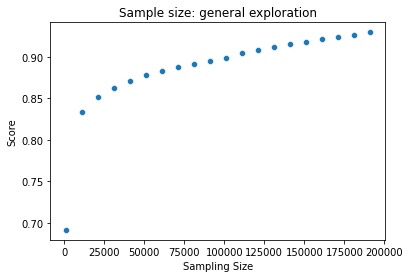

In [ ]:
plot_sample_size_experiment(1000, 200000, 10000, "Sample size: general exploration")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


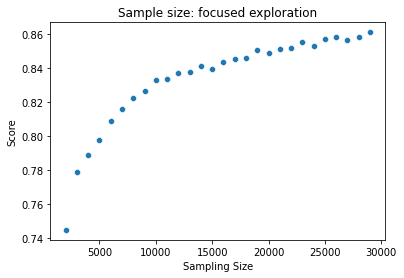

In [ ]:
plot_sample_size_experiment(2000, 30000, 1000, "Sample size: focused exploration")

### 2.2 Feature Importance
#### We analize feature importance by dropping each column and considering its impact in model's score

In [ ]:
def experiment_drop_column(sample_n):
  sample_exp_scores = []
  
  columns_to_drop = train_data.columns.to_list()
  columns_to_drop.remove('Fraud')

  for column_to_drop in columns_to_drop:

    train_dataset_exp = train_data.drop(column_to_drop, axis=1)

    df_train0 = train_dataset_exp[train_dataset_exp['Fraud']==0].sample(n=sample_n, replace=False, random_state=1)
    df_train1 = train_dataset_exp[train_dataset_exp['Fraud']==1].sample(n=sample_n, replace=True, random_state=1)

    df_train_sample = pd.concat([df_train1,df_train0], axis=0,ignore_index=True)
    X = df_train_sample.iloc[:,:-1]
    y = df_train_sample.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    pipeline = Pipeline([('clf', KNeighborsClassifier(n_neighbors=5))])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)

    sample_exp_scores.append(np.mean(scores))

  return sample_exp_scores


We chose n_sample_size = 20 0000 since from there sample size experiment's curve seems to flatten

In [ ]:
scores_for_different_columns_subsets = experiment_drop_column(20000)

In [ ]:
columns_to_drop = train_data.columns.to_list()
columns_to_drop.remove('Fraud')

In [ ]:
pd.DataFrame({'feature': columns_to_drop, 'score without feature': scores_for_different_columns_subsets}).sort_values(by='score without feature')

,feature,score without feature
3,ScannedProducts,0.691929
0,LevelOfTrust,0.828000
5,ActivateWithoutScan,0.846679
4,CountOfVoidedScans,0.848643
6,ModifiedQuantities,0.851143
2,TotalBasketValue,0.901714
1,ScanTimeInSeconds,0.933714


From dropping analysis in KNN, we conclude that:

- Delete: 'TotalBasketValue' and 'ScanTimeInSeconds', because it seems to affects our score negatively, given the if we drop them, we get a significantly better score (0.85 < 0.90 & 0.85 < 0.93)
- Keep: 'ScannedProducts', because it seems to be important, given the if we drop them, we get a significantly worst score (0.85 > 0.69)

If we use all features we get a testing score of: 0.85

### 2.3 Random Forest
We applied what we have learnt about dataset characterisctics and sampling techniques in a more complex model. 

#### Feature analysis:
We repeat our previous feature importance analysis running now many times to minimize variations due to data particular sampling performed 

In [ ]:

def checking_drop_exp_random_forest(sample_size_range, runs, columns_to_drop):

  seeds = [seed for seed in range(1, runs+1)]
  
  sample_exp_scores = np.zeros(len(sample_size_range))

  for seed in seeds:

    for index, sample_n in enumerate(sample_size_range):
      train_dataset_exp = train_data.drop(columns_to_drop, axis=1)

      df_train0 = train_dataset_exp[train_dataset_exp['Fraud']==0].sample(n=sample_n, replace=False, random_state=seed)
      df_train1 = train_dataset_exp[train_dataset_exp['Fraud']==1].sample(n=sample_n, replace=True, random_state=seed)

      df_train_sample = pd.concat([df_train1,df_train0], axis=0,ignore_index=True)
      X = df_train_sample.iloc[:,:-1]
      y = df_train_sample.iloc[:,-1]
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

      pipeline = Pipeline([('clf', RandomForestClassifier(n_estimators = 100, n_jobs=-1))])
      scores = cross_val_score(pipeline, X_train, y_train, cv=5,n_jobs=-1)

      sample_exp_scores[index]+= np.mean(scores)
  
  sample_exp_scores/=runs
  return sample_exp_scores


In [ ]:
def plot_drop_two_worst_columns_random_forest(start, end, step, runs,columns_to_drop=[], title="Sample size experiment"):
  sampling_size_range = [n for n in range(start, end, step)]
  sample_exp_scores = checking_drop_exp_random_forest(sampling_size_range, runs,columns_to_drop)
  ax = sns.scatterplot(sampling_size_range, sample_exp_scores)
  ax.set_title(title+": dropping " + str(columns_to_drop)) 
  ax.set_ylabel("Score")
  ax.set_xlabel("Sample Size")
  return sample_exp_scores

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


array([0.97475714, 0.97558442, 0.97507143, 0.97551648, 0.97490816,
       0.97561905, 0.97616071, 0.9759916 , 0.97627778, 0.97578195,
       0.97604286, 0.97629932, 0.97672078, 0.97624845, 0.9770119 ,
       0.97700571, 0.97744505, 0.97726984, 0.97734184, 0.97774384])

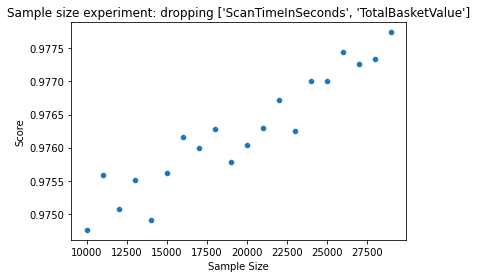

In [ ]:
plot_drop_two_worst_columns_random_forest(10000, 30000, 1000, 5,['ScanTimeInSeconds', 'TotalBasketValue'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


array([0.99040476, 0.99041126, 0.99075397, 0.99089744, 0.99102041,
       0.99119048, 0.99197917, 0.99238095, 0.9922619 , 0.99220551,
       0.99254762, 0.99267574, 0.99274892, 0.99320911, 0.9930754 ,
       0.99317143, 0.99318681, 0.99355379, 0.99358844, 0.99359606])

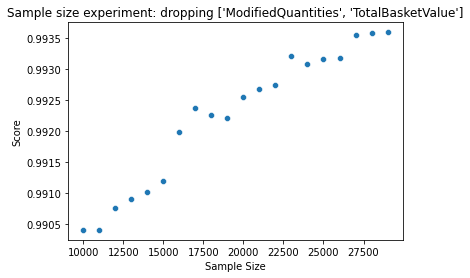

In [ ]:
plot_drop_two_worst_columns_random_forest(10000, 30000, 1000, 3,['ModifiedQuantities', 'TotalBasketValue'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


array([0.98833333, 0.98807359, 0.98878968, 0.98901099, 0.98892857,
       0.98950794, 0.98977679, 0.99012605, 0.99041005, 0.99068922,
       0.99091667, 0.9910771 , 0.9909632 , 0.99149068, 0.99147817,
       0.99155238, 0.99177656, 0.9918254 , 0.9919898 , 0.99218391])

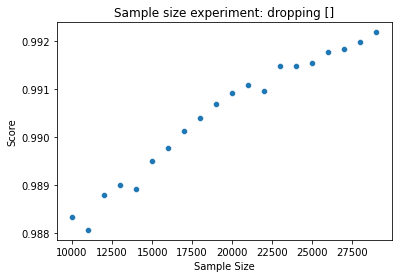

In [ ]:
plot_drop_two_worst_columns_random_forest(10000, 30000, 1000, 3 , [])

We conclude that for RandomForest considering all features is the best option

############ Todo: from here code refactor neeeded

In [ ]:
def prepare_and_train(dataset, fraud_num, non_fraud_num, seed):

  df_train0 = dataset[dataset['Fraud']==0].sample(n=non_fraud_num, replace=False, random_state=seed)
  df_train1 = dataset[dataset['Fraud']==1].sample(n=fraud_num, replace=True, random_state=seed)

  df_train_sample = pd.concat([df_train1,df_train0], axis=0,ignore_index=True)

  X = df_train_sample.iloc[:,:-1]
  y = df_train_sample.iloc[:,-1]

  rfc = RandomForestClassifier(n_jobs=-1, random_state=seed)
  rfc.fit(X, y)

  return rfc

In [ ]:
def calculate_profit(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)
  profit = cf_matrix[1][1] * 5 - cf_matrix[1][0] * 25 - cf_matrix[0][1] * 5
  return profit

In [ ]:
def calculate_avg_profit_using_target_training_proportion(train_data, cant_fraud, cant_non_fraud, X_test_whole_dataset, y_test_whole_dataset, runs = 1):

  seeds = [seed for seed in range(1, runs + 1)]
  
  profit = 0

  for seed in seeds:
    model = prepare_and_train (train_data, cant_fraud, cant_non_fraud, seed)
    predicted_y_whole_dataset = model.predict(X_test_whole_dataset) 
    profit += calculate_profit (y_test_whole_dataset, predicted_y_whole_dataset)
  
  return profit/runs

In [ ]:
def profit_fraud_non_fraud_range(dataset,range_fraud,range_non_fraud,runs):
  X_test_whole_dataset = dataset.iloc[:,:-1]
  y_test_whole_dataset = dataset.iloc[:,-1]

  profit_array = []
  num_fraud_array = []
  num_non_fraud_array = []

  cant_fraud = range_fraud
  cant_non_fraud = range_non_fraud
  for cant_fraud in range_fraud:
    for cant_non_fraud in range_non_fraud:
      profit = calculate_avg_profit_using_target_training_proportion(train_data, cant_fraud, cant_non_fraud, X_test_whole_dataset, y_test_whole_dataset, runs)
      profit_array.append(profit)
      num_fraud_array.append(cant_fraud)
      num_non_fraud_array.append(cant_non_fraud)
      #print (str(profit) + " " + str(cant_fraud) + " " + str(cant_non_fraud))
  return {"profit":profit_array,"num_fraud":num_fraud_array,"num_non_fraud":num_non_fraud_array}

In [ ]:
def plotly_3d_scatter(dictionary):
  df = pd.DataFrame(dictionary)
  fig = px.scatter_3d(df, x='num_fraud', y='num_non_fraud', z='profit')
  fig.show()

In [ ]:
large_exploration_results = profit_fraud_non_fraud_range(train_data, list(range(1000, 12000,3000)),list(range(5000,200000,15000)), runs = 4)

NameError: ignored

In [ ]:
plotly_3d_scatter(large_exploration_results)

In [ ]:
results_zoom = profit_fraud_non_fraud_range(train_data, list(range(8000, 11000,1000)),list(range(55000,110000,4000)), runs= 4)

In [ ]:
plotly_3d_scatter(results_zoom)

### 2.4 Final model
We decided to use Random Forest as our final model. Based on grid search exploration, profit's maximization occurs when:
  - non-fraud sample size is: ~65000
  - fraud sample size is: ~9000



In [ ]:
X_test_whole_dataset = train_data.iloc[:,:-1]
y_test_whole_dataset = train_data.iloc[:,-1]

model = prepare_and_train (train_data, 9000,65000)
predicted_y_whole_dataset = model.predict(X_test_whole_dataset)

In order to analyze our final ML model, we used confusion matrix to verify its performance in the whole dataset considering other metrics.

#### Confusion matrix heatmap

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def print_confusion_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)
  group_names = ['TP `Not Fraud`', 'FP: Refused `Fraud`', 'FN: Refused `Not Fraud`', 'TN `Fraud`']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
  precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
  recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  sns.heatmap(cf_matrix, annot=labels, fmt='')
  stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
  plt.ylabel('True label')
  plt.xlabel('Predicted label' + stats_text)

 FN and FP seems to be minimized, getting not only a good accuracy but also good recall and F1 score.

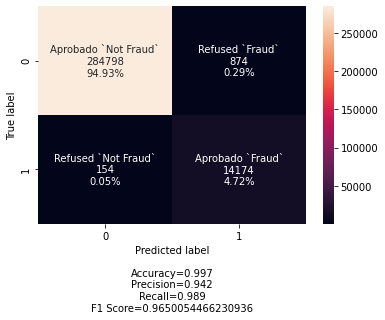

In [ ]:
print_confusion_matrix(y_test_whole_dataset,predicted_y_whole_dataset)

### Final prediction
We applied the final model to the scoring dataset, obtaining predicted labels to submit.

In [ ]:
set_to_be_scored_prediction = model.predict(set_to_be_scored)
final_prediction_df = pd.DataFrame(set_to_be_scored_prediction, columns=["Fraud"])
final_prediction_df.value_counts()

Fraud
0        94932
1         5068
dtype: int64

Export final result from dataframe to as a csv file

In [ ]:
final_prediction_df.to_excel('results.xlsx', sheet_name='Fraud Detection in Retail')

#### Auxiliar code not used to get final model

In [ ]:
train_dataset_exp = train_data
#train_dataset_exp = train_data.drop(['ModifiedQuantities', 'TotalBasketValue'], axis=1)

df_train0 = train_dataset_exp[train_dataset_exp['Fraud']==0].sample(n=30000, replace=False, random_state=42)
df_train1 = train_dataset_exp[train_dataset_exp['Fraud']==1].sample(n=15000, replace=True, random_state=42)

df_train_sample = pd.concat([df_train1,df_train0], axis=0,ignore_index=True)
X = df_train_sample.iloc[:,:-1]
y = df_train_sample.iloc[:,-1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


n_estimators = [40,60,80, 100]
max_depth = [6,7,8,10]
min_samples_leaf = [1,2,5] 


rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rfc, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

test_res = bestF.predict(X_test)
accuracy = accuracy_score(y_test, test_res)
accuracy

In [ ]:
from sklearn.metrics import accuracy_score

train_dataset_exp = train_data
#train_dataset_exp = train_data.drop(['ModifiedQuantities','TotalBasketValue','CountOfVoidedScans','ActivateWithoutScan'], axis=1)

df_train0 = train_dataset_exp[train_dataset_exp['Fraud']==0].sample(n=2000, replace=False, random_state=42)
df_train1 = train_dataset_exp[train_dataset_exp['Fraud']==1].sample(n=2000, replace=True, random_state=42)

df_train_sample = pd.concat([df_train1,df_train0], axis=0,ignore_index=True)
X = df_train_sample.iloc[:,:-1]
y = df_train_sample.iloc[:,-1]


rfc = RandomForestClassifier(n_estimators = 100, n_jobs=-1,random_state = 42)
rfc.fit(X_train,y_train)
pd.Series(rfc.feature_importances_, index=X.columns).sort_values()
#rfc = RandomForestClassifier(n_estimators = 100, n_jobs=-1,random_state=42)
#scores = cross_val_score(rfc, X_test, y_test, cv=5,n_jobs=-1)
#scores

df_test = train_dataset_exp[train_dataset_exp['Fraud']==1].iloc[:,:-1]
df_test_y = train_dataset_exp[train_dataset_exp['Fraud']==1].iloc[:,-1]
test_res = rfc.predict(df_test)
accuracy = accuracy_score(df_test_y, test_res)
accuracy